# Custom dataloader
Example of creating custom dataset with specific transformation pipeline using Torch Dataset and DataLoader Classes 

In [7]:
from matplotlib import pyplot as plt 
from torchvision import transforms

## Data Loader:

In [8]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import cv2

class CatDogDataset(Dataset):
    """Custom Cats vs Dogs Torch Dataset Class"""

    def __init__(self, root_dir, transform=None):
        """Class initialises with a path to the dataset directory"""
        self.root_dir = root_dir
        self.image_file = self._getcsv()
        self.transform = transform
        
    def _getcsv(self):
        """Create pandas dataframe with image path and lable"""
        image_ext = ['jpg', 'png']
        d = {"path":[], "label":[]}

        for root, dirs, files in os.walk(self.root_dir, topdown=False):
            for name in files:
                ext = name.split(".")
                if ext[-1] in image_ext:
                    path = root.split(os.sep)
                    path.append(name)
                    label = path[-2]
                    p = os.path.join(*path)
                    d["path"].append(p)
                    d["label"].append(label)
                    
        return pd.DataFrame(data=d)
        
    def __len__(self):
        """Len of dataset"""
        return len(self.image_file)
    
    def __getitem__(self, idx):
        """Get item override"""
        if torch.is_tensor(idx):
            idx = idx.tolist()

        label = self.image_file.iloc[idx, 0]
        img_path = self.image_file.iloc[idx, 1]
        
        image = cv2.imread(img_path)
        sample = {'image': image, 'label': label}

        if self.transform:
            sample = self.transform(sample)

        return sample
    

class Rescale(object):
    """Rescale the sample image to a given size."""

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)
        img = cv2.resize(image, (new_w, new_h))

        return {'image': img, 'label': label}
    
    
class ToTensor(object):
    """Convert ndarray sample to a Tensor"""

    def __call__(self, sample):
        image, label = sample['image'], sample['label']
         
        # if image has no color channel, add RGB
        if(len(image.shape) == 2):
            # add that third color dim
            image = image.reshape(image.shape[0], image.shape[1], 3)
            
        # Swap color axis into tourch representation
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        
        return {'image': torch.from_numpy(image),
                'label': label}

## Example of use

In [9]:
# Create data transform pipeline:
data_transform = transforms.Compose([Rescale((250,250))]) #ToTensor()

# Create dataset:
transformed_dataset = CatDogDataset(root_dir='data/datasets/PetImages', transform=data_transform)

# Create Dataloader:
# Load train and test data into batches:
train_loader = DataLoader(transformed_dataset, 
                          batch_size=32, 
                          shuffle=True,  
                          num_workers=0)

In [10]:
# Get specyfic batch of samples:
sample_batch = transformed_dataset[1]
sample_img, sample_label = sample_batch['image'], sample_batch['label']

print(sample_label)

Cat


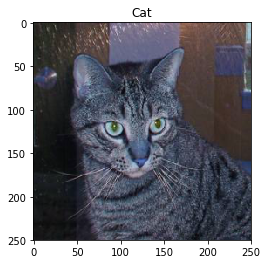

In [11]:
plt.imshow(sample_img)
plt.title(sample_label)
plt.show();

In [12]:
#Get next batch of samples:
sample_batch = next(iter(train_loader))

print("Batch is a dictionary:", sample_batch.keys())
print("Shape of images stored:", sample_batch['image'].shape)
print("Shape of labels stored:", len(sample_batch['label']))

Batch is a dictionary: dict_keys(['image', 'label'])
Shape of images stored: torch.Size([32, 250, 250, 3])
Shape of labels stored: 32
